In [1]:
import sys
sys.path.append("..")

import os
import glob
import numpy as np

%load_ext autoreload
%autoreload 2

from sicm import io, plots, model

# Simulations
## Current-distance characterstic

In [2]:
parent = "S:/UsersData/Martin/projects/thermometry/comsol/I_vs_d/3/"
files = glob.glob(parent + "*.txt")
print(files)

['S:/UsersData/Martin/projects/thermometry/comsol/I_vs_d/3\\ecJz.txt', 'S:/UsersData/Martin/projects/thermometry/comsol/I_vs_d/3\\ecJ3D.txt']


Saved figure to I_vs_d_curve.pdf.


C:\Users\mholub\AppData\Local\Continuum\miniconda3\envs\sicm\lib\site-packages\matplotlib\__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
C:\Users\mholub\AppData\Local\Continuum\miniconda3\envs\sicm\lib\site-packages\matplotlib\__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
C:\Users\mholub\AppData\Local\Continuum\miniconda3\envs\sicm\lib\site-packages\matplotlib\__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


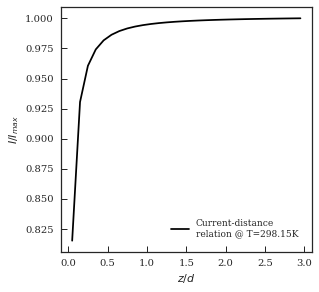

In [3]:
# Current-distance simulation
data = io.load_comsol(files[0])
r_i = 15e-9
x = data.iloc[:, 0] / (r_i*2) # scale by diameter
y = np.asarray(data.iloc[:, 1]) # convert to nanoAmps
y_max = np.max(y) if y[-1] > 0 else np.min(y)
y = y/y_max
leg = "Current-distance relation @ T=298.15K"
plots.plot_generic([x], [y], [r"$z/d$"], [r"$I/I_{max}$"], leg, "I vs. d curve")

## Current-temperature characteristic

You may need to rerun the simulation and sample current also at d = `some-very-high-value` in order to plot relative current as well.

['S:/UsersData/Martin/projects/thermometry/comsol/I_vs_Tsub/3\\ecJz.txt', 'S:/UsersData/Martin/projects/thermometry/comsol/I_vs_Tsub/3\\ecJ3D.txt']
Saved figure to I_vs_Tsub_curve.pdf.


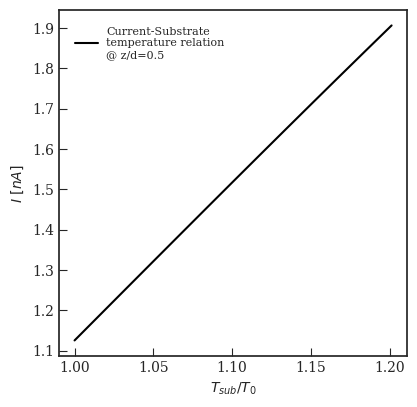

In [4]:
# Current-Tsub simulation
parent = "S:/UsersData/Martin/projects/thermometry/comsol/I_vs_Tsub/3/"
files = glob.glob(parent + "*.txt")
print(files)

data = io.load_comsol(files[0])
x = data.iloc[:, 0] / (data.iloc[0, 0]) # scale by room temperature
y = np.abs(data.iloc[:, 2])*1e9 # convert to nanoAmps
leg = "Current-Substrate temperature relation @ z/d=0.5"
plots.plot_generic([x], [y], [r"$T_{sub}/T_{0}$"], [r"$I\ [nA]$"], leg, "I vs. Tsub curve")

# Analytical model

Saved figure to I_vs_z_curve.pdf.


C:\Users\mholub\AppData\Local\Continuum\miniconda3\envs\sicm\lib\site-packages\matplotlib\__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
C:\Users\mholub\AppData\Local\Continuum\miniconda3\envs\sicm\lib\site-packages\matplotlib\__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
C:\Users\mholub\AppData\Local\Continuum\miniconda3\envs\sicm\lib\site-packages\matplotlib\__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


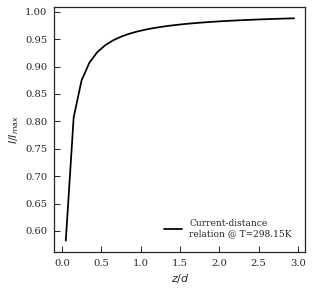

In [3]:
# Analytical Model
r_i = 15e-9
U = 0.1
kappa = 3.7 # 1/(Ohm*m), read from plot for T = 298.15K, can calculate later
h = 23e-6
r_p = 2e-6
r_o = 26e-9
z = np.arange(r_i/10, 6*r_i, r_i/5)

sicm_model = model.SICMModel(z, U, h, kappa, r_p, r_i, r_o)
sicm_model.plot(do_invert = False)

# Plot Analytical and Numerical Model Together

In [2]:
parent = "S:/UsersData/Martin/projects/thermometry/comsol/recovered/I_vs_d/5/"
files = glob.glob(parent + "*.txt")
print(files)

['S:/UsersData/Martin/projects/thermometry/comsol/recovered/I_vs_d/5\\ecJz.txt', 'S:/UsersData/Martin/projects/thermometry/comsol/recovered/I_vs_d/5\\ecJ3D.txt']


In [3]:
# Current-distance simulation
data = io.load_comsol(files[0])
r_i = 15e-9
x = data.iloc[:, 0] / (r_i*2) # scale by diameter
y = np.asarray(data.iloc[:, 1]) # convert to nanoAmps
y_max = np.max(y) if y[-1] > 0 else np.min(y)
y = y/y_max

In [4]:
# Analytical Model
U = 0.1
kappa = 3.7 # 1/(Ohm*m), read from plot for T = 298.15K, can calculate later
h = 23e-6 # some arbitrary value
r_p = h * np.tan(4.78 * np.pi/180)  # we know the angle
r_o = 26e-9

z = x * (2*r_i) # convert to nanometers

sicm_model = model.SICMModel(z, U, h, kappa, r_p, r_i, r_o)

#### Additional explanation
For `r_o`, `18e-9` will give almost perfect fit whereas `26e-9` is according parameters in COMSOL. This discrepancy is not unexpected, because in COMSOL the pipette has "barrel" at its opening, which is not considered in the analytical model.

Similar effect could be achieved by reducing the angle $\alpha$ (to about 2.5).

In [10]:
thresh = 1.0
# Simulation
xx = x[x<=thresh]
yy = y[x<=thresh]
# Model
xx_m = x[x<=thresh]
y_m = sicm_model.I / (sicm_model.U/sicm_model.R_p)
yy_m = y_m[x<=thresh]

Saved figure to I_vs_d_curve_both.pdf.


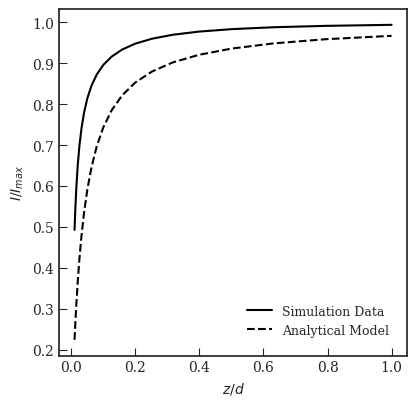

In [68]:
leg = ["Simulation Data", "Analytical Model"]
plots.plot_generic([xx, xx_m], [yy, yy_m], 
                   [r"$z/d$"], [r"$I/I_{max}$"], leg, "I vs. d curve_both")

# Fit functional relationship to data

Fit function of the form of an analytical model to the simulations data. Use inverted relationship $d = f(I)$ and prefer to work with scaled values $\frac{d}{2r_i} = f(\frac{I}{I_{max}})$.

Physical interperatation of parameters is possible. $\alpha$ is the inner opening angle of the pipette and $r_o$ is the outter diameter at the tip opening.

Quality of the fit decreases with wider range $z/d$. Good balance spans relevant distances while still giving good fit.

Fitting SICMModel.fit_wrapper.<locals>._inverse_fit to 18 datapoints ...
Found parameters: [3.57732100e+00 1.83566047e-08].
Finished in 0.002 s
error on fit: 2.401766554E-02


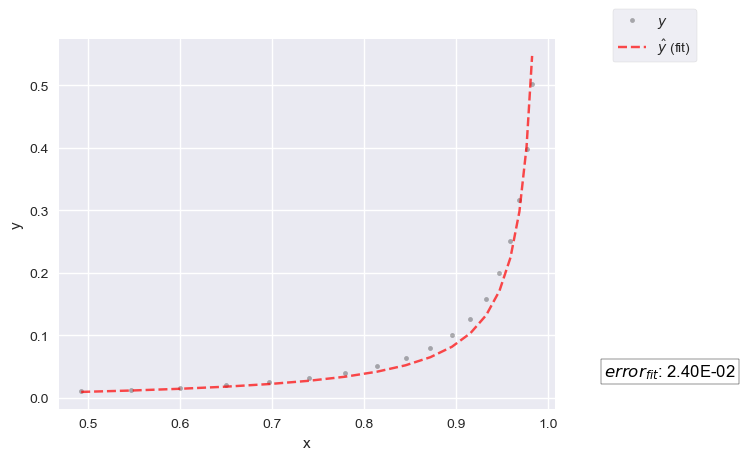

In [65]:
guess = [4.78, 18e-9]
sicm_model.fit_approach(x[:-13], y[:-13], guess, False)

Saved figure to I_vs_d_curve_fit.pdf.


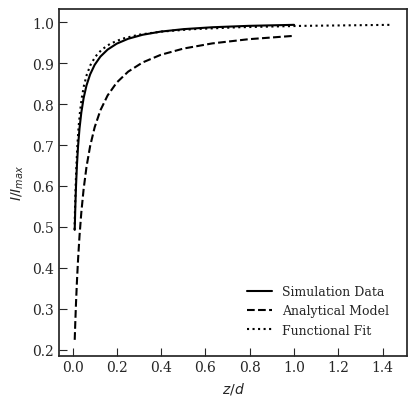

In [67]:
leg = ["Simulation Data", "Analytical Model", "Functional Fit"]
plots.plot_generic([xx, xx_m, sicm_model.predict(yy, sicm_model.popt)], [yy, yy_m, yy], 
                   [r"$z/d$"], [r"$I/I_{max}$"], leg, "I vs. d curve fit")

## Get distance from experimental data

In [71]:
'S:/UsersData/Martin/2018/12_Dec/21\\scan1_annot.pkl'

# data_dir = "S:/UsersData/Martin/2018/12_Dec/12/sicm/exp1"
# exp_name = "scan_hopping_qtf_current"

data_dir = "S:/UsersData/Martin/2018/12_Dec/21"
exp_name = "scan1"

df = io.load_dataframe([data_dir, exp_name + "_annot.pkl"])

Saved figure to scan1_feedback_distance.pdf.


C:\Users\mholub\AppData\Local\Continuum\miniconda3\envs\sicm\lib\site-packages\matplotlib\__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
C:\Users\mholub\AppData\Local\Continuum\miniconda3\envs\sicm\lib\site-packages\matplotlib\__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
C:\Users\mholub\AppData\Local\Continuum\miniconda3\envs\sicm\lib\site-packages\matplotlib\__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


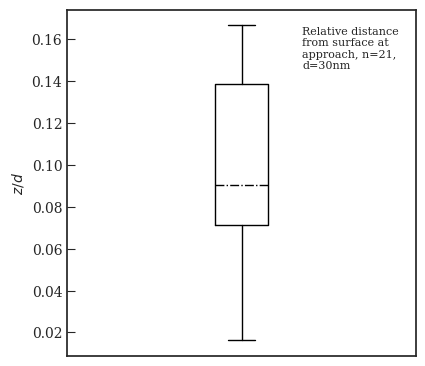

In [72]:
i_exp = df["Current1(A)"]["peaks_val"]/df["Current1(A)"]["baseline"]
z_rel = sicm_model.predict(i_exp)
legend = "Relative distance from surface at approach," + \
        " n={}, d={:.0f}nm".format(len(z_rel), np.round(2*r_i*1e9))
plots.boxplot_generic(z_rel, "", r"$z/d$", legend = legend,
                     fname = exp_name + "_feedback_distance")

## Fit functional relationship to data (Old Version)

In [4]:
# obtain a model that yields distance for some measured current
r_i = 15e-9
U = 0.1
kappa = 3.7 # 1/(Ohm*m), read from plot for T = 298.15K, can calculate later
h = 23e-6
r_p = 2e-6
r_o = 26e-9
z = np.arange(r_i/10, 6*r_i, r_i/5)

# continue here by fitting inverse relationship
sicm_model = model.SICMModel(z, U, h, kappa, r_p, r_i, r_o)

In [5]:
parent = "S:/UsersData/Martin/projects/thermometry/comsol/I_vs_d/4/"
files = glob.glob(parent + "*.txt")
data = io.load_comsol(files[0])
z = data.iloc[:, 0]
i = np.abs(np.asarray(data.iloc[:, 1]))
i_max = np.max(i)

### Version A 

Fitting SICMModel.fit_wrapper.<locals>._inverse_fit to 50 datapoints ...
Found parameters: [9.31186278e-07 4.09167025e-05 1.06888822e+01].
Finished in 0.004 s
error on fit: 1.250599772E-01


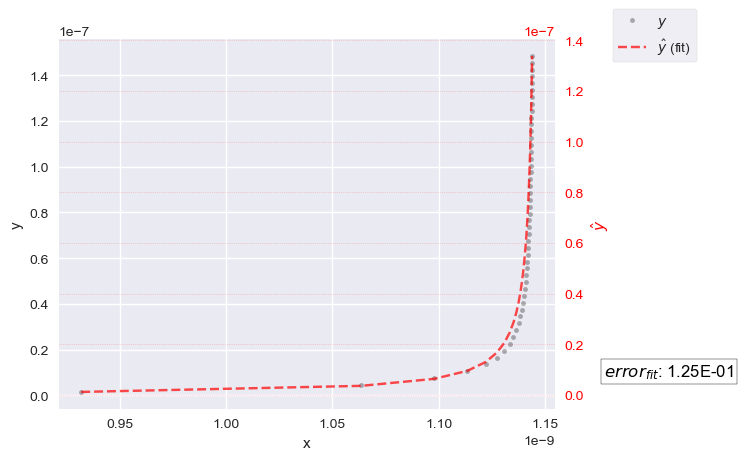

In [6]:
guess = [r_p, h, kappa**2]
sicm_model.fit_approach(z, i, guess)

error on fit: 1.250599772E-01


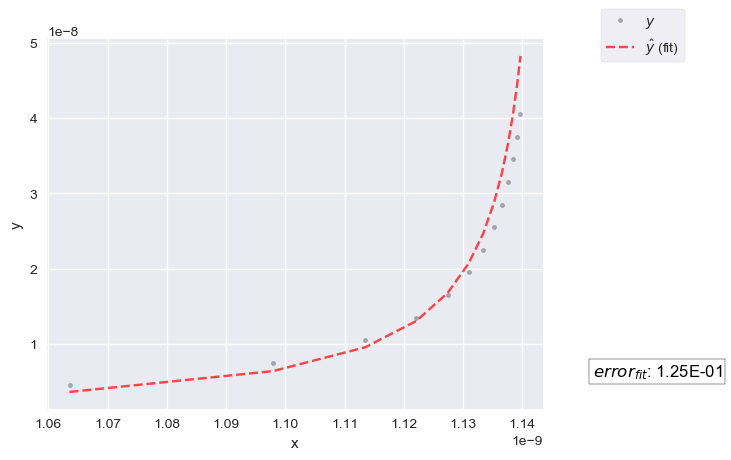

In [7]:
sicm_model.plot_fit(z, i, plot_range = [1.05e-9, 1.14e-9])

### Version B

Fitting SICMModel.fit_wrapper.<locals>._inverse_fit to 50 datapoints ...
Found parameters: [-3.43704563e-07 -5.93633046e-13  3.67068962e+02].
Finished in 0.004 s
error on fit: 2.041555755E-02


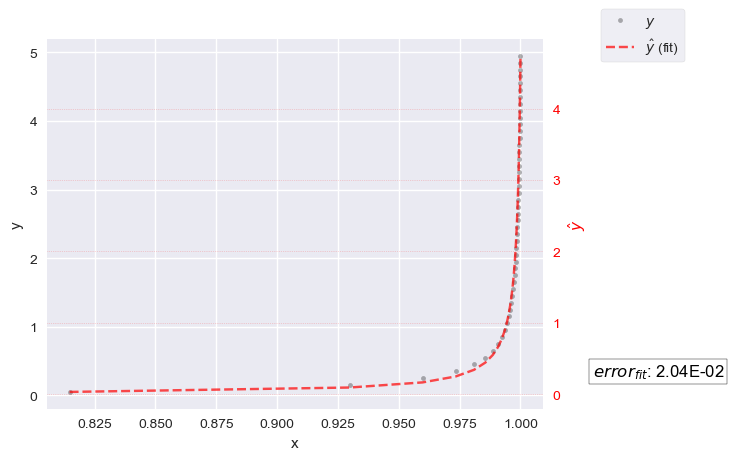

In [36]:
guess = [r_p, h*r_i/4,(kappa)/np.sqrt((i_max/U))]
sicm_model.fit_approach(z/(2*r_i), i/i_max, guess)

error on fit: 2.041555755E-02


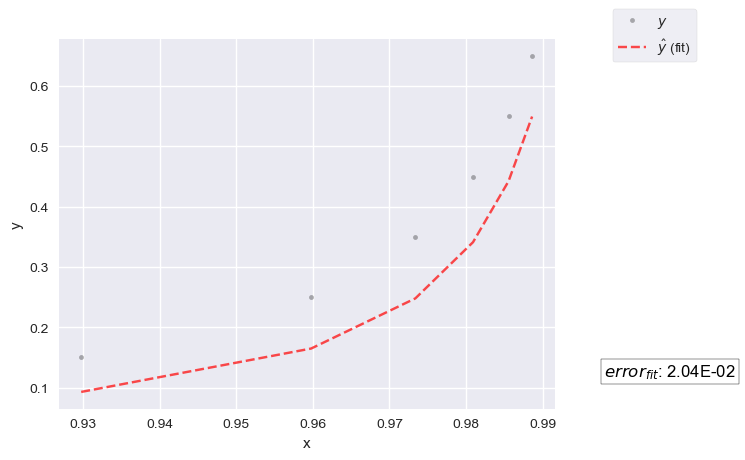

In [37]:
sicm_model.plot_fit(z/(2*r_i), i/i_max, plot_range = [0.925, .99])